## 🧠 Alzheimer's Disease Classification
### The data in total consists of 6400 images.

## Mobile Net Model

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
# from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Loading Data

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

### Data Splitting Train, test and validation

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


### MODEL BUILDING

In [6]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

17225924/17225924 [==============================] - 0s 0us/step


### Freezing Layers

In [7]:
for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 batch_normalization_1 (Batc  (None, 32)               1

### F1 Score Function

In [9]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Model Metrics

In [10]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

### Adding Loss function, model metrics...

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [12]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20


2023-04-01 17:09:46.808829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


129/129 [==============================] - 74s 498ms/step - loss: 1.0861 - accuracy: 0.7554 - precision: 0.5219 - recall: 0.2560 - auc: 0.7732 - f1_score: 0.3400 - val_loss: 0.9584 - val_accuracy: 0.7849 - val_precision: 0.5994 - val_recall: 0.4213 - val_auc: 0.8260 - val_f1_score: 0.4955 - lr: 0.0100
Epoch 2/20
129/129 [==============================] - 51s 397ms/step - loss: 0.9946 - accuracy: 0.7792 - precision: 0.6497 - recall: 0.2531 - auc: 0.8066 - f1_score: 0.3642 - val_loss: 0.9615 - val_accuracy: 0.7942 - val_precision: 0.6511 - val_recall: 0.3812 - val_auc: 0.8314 - val_f1_score: 0.4790 - lr: 0.0063
Epoch 3/20
129/129 [==============================] - 50s 390ms/step - loss: 0.9574 - accuracy: 0.7883 - precision: 0.6908 - recall: 0.2775 - auc: 0.8203 - f1_score: 0.3920 - val_loss: 0.9149 - val_accuracy: 0.7942 - val_precision: 0.6874 - val_recall: 0.3245 - val_auc: 0.8345 - val_f1_score: 0.4375 - lr: 0.0040
Epoch 4/20
129/129 [==============================] - 50s 388ms/step 

### Plotting Model Evaluation

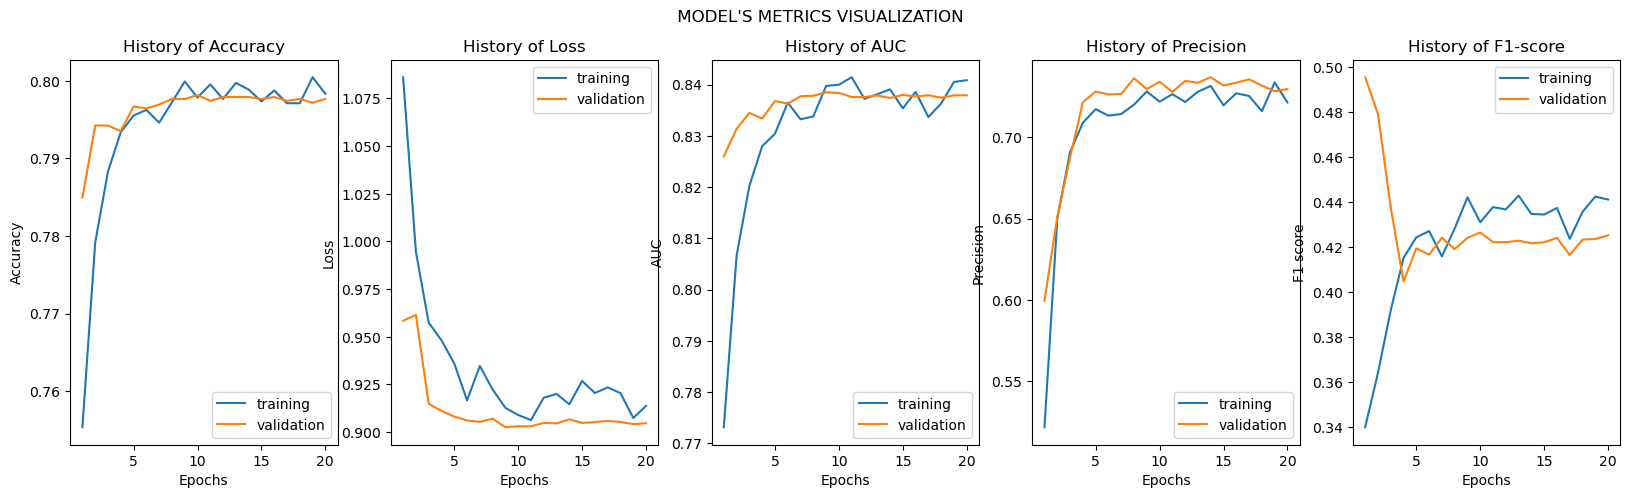

In [13]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )


### Model's Accuracy

In [14]:
scores = model.evaluate_generator(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy =  0.7935887575149536
Precision =  0.6613603234291077
Recall =  0.35731038451194763
AUC =  0.830737292766571
F1_score =  0.46125778555870056


## Mobile NET V2 Model

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


### Freezing Layers of the transferred model

In [16]:
for layer in base_model.layers:
    layer.trainable=False

### Building Model

In [17]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 62720)            250880    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                2007072   
                                                                 
 batch_normalization_5 (Batc  (None, 32)              

### Model metrics, loss function and optimizer

In [18]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

### Fitting the Model

In [19]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20


2023-04-01 17:27:01.740285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


129/129 [==============================] - 56s 396ms/step - loss: 1.0912 - accuracy: 0.7601 - precision: 0.5405 - recall: 0.2693 - auc: 0.7848 - f1_score: 0.3235 - val_loss: 1.0138 - val_accuracy: 0.7735 - val_precision: 0.5777 - val_recall: 0.3490 - val_auc: 0.7966 - val_f1_score: 0.4328 - lr: 0.0100
Epoch 2/20
129/129 [==============================] - 49s 380ms/step - loss: 1.0117 - accuracy: 0.7713 - precision: 0.6031 - recall: 0.2491 - auc: 0.7996 - f1_score: 0.3467 - val_loss: 1.0317 - val_accuracy: 0.7717 - val_precision: 0.6072 - val_recall: 0.2463 - val_auc: 0.7895 - val_f1_score: 0.3472 - lr: 0.0063
Epoch 3/20
129/129 [==============================] - 50s 383ms/step - loss: 0.9840 - accuracy: 0.7808 - precision: 0.6524 - recall: 0.2638 - auc: 0.8112 - f1_score: 0.3756 - val_loss: 1.0066 - val_accuracy: 0.7744 - val_precision: 0.6068 - val_recall: 0.2776 - val_auc: 0.7959 - val_f1_score: 0.3779 - lr: 0.0040
Epoch 4/20
129/129 [==============================] - 50s 384ms/step 

### Plotting model evaluation

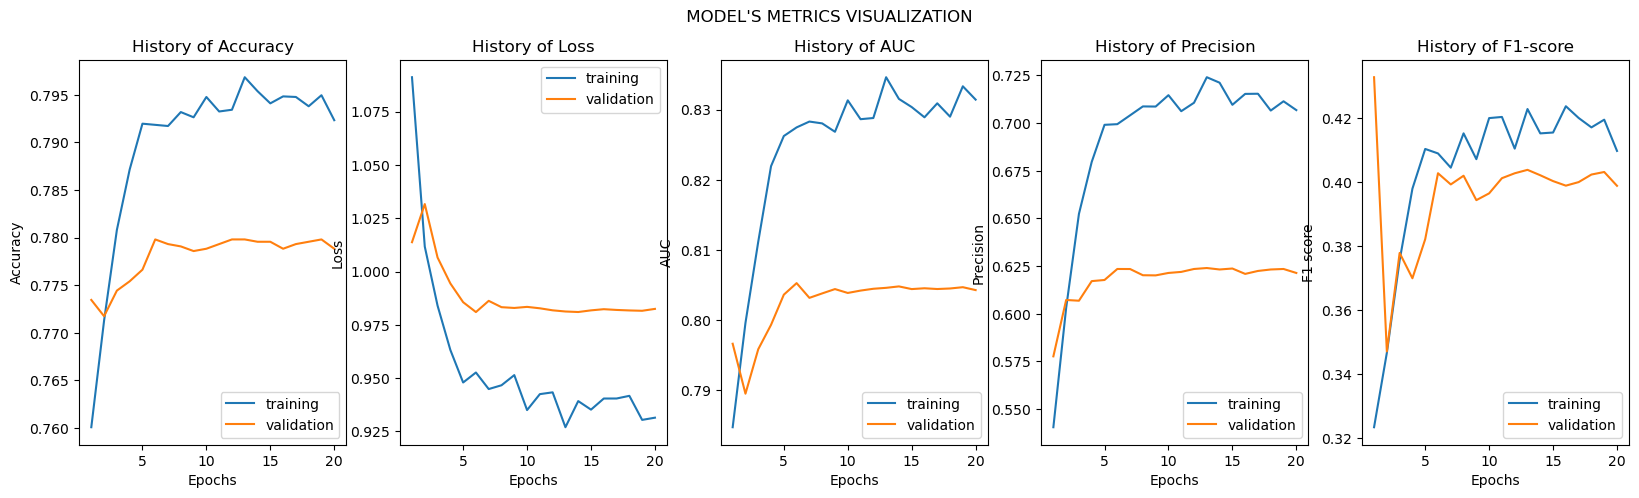

In [20]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

### Model's Accuracy

In [21]:
scores = model.evaluate_generator(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy =  0.7847927808761597
Precision =  0.6080096960067749
Recall =  0.3917122781276703
AUC =  0.8232438564300537
F1_score =  0.4737083911895752
